In [1]:
import random
import numpy as np
from numpy.random import normal as noise
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as normal
from scipy.stats import norm
import linear_model.linear_model as lm
from linear_model.linear_model import BayesianLinearModel

# Ejercicio 1

In [2]:
def simular1(N=5000, do_x=None):
    # Si hay intervencion, usar x = do_x, sino generarlo del modelo original
    Z = np.random.uniform(-3,3, size=N)
    if do_x is None:
        X = 1 + 3*Z + 2*Z**3 + np.random.normal(size=N,scale=6)
    else:
        X = np.full(N, do_x)
    Y = -1 - 2*X + 6*Z**2 + np.random.normal(size=N,scale=1)
    return Z, X, Y

 # Generamos los datos sin intervenciones
N = 5000
Z1s, X1s, Y1s = simular1(N)
# Creamos el modelo
PHI1 = np.concatenate([
    np.ones(N).reshape(N, 1), # c_0
    X1s.reshape(N, 1), # c_x X
    (Z1s**2).reshape(N, 1)], # c_z Z^2
    axis=1)

# Ajustamos el modelo
blm1= BayesianLinearModel(basis=lambda x: x)
blm1.update(PHI1, Y1s.reshape(N,1) )

# Obtenemos las estimaciones
mean1 = blm1.location
cov1 = blm1.dispersion
ev1 = blm1.evidence()

In [3]:
mean1, cov1, ev1

(array([[-0.97992696],
        [-1.99965408],
        [ 5.99798329]]),
 array([[ 4.53556735e-04, -3.58405229e-07, -8.45442619e-05],
        [-3.58405229e-07,  2.98339977e-07,  4.82196669e-08],
        [-8.45442619e-05,  4.82196669e-08,  2.82069347e-05]]),
 np.float64(-7122.063864637417))

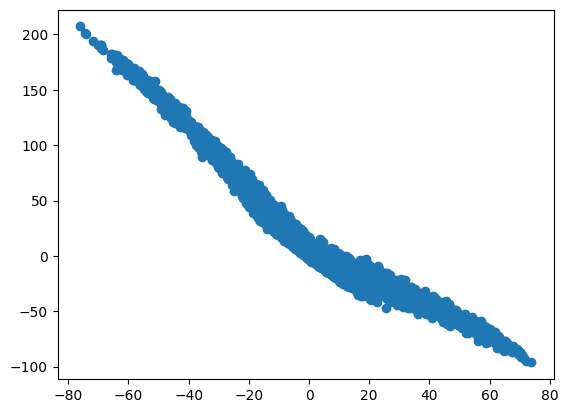

In [4]:
plt.scatter(X1s,Y1s)

queremos calcular P(y|do(x)) = sum_z P(y,z|do(x)) = sum_z P(y|do(x),z) P(z|do(x))   = sum_z P y | x,z   P z

Para eso usamos el modelo bayesiano ajustado para generar las "predicciones" (la probabilidad de y dado x y z)

In [5]:
def p1_Y_doX(y,x,blm1=blm1,dz=0.01):
    # Backdoor
    # P(y) | do(x)) = int_z p(y|x,z) p(z) dz
    
    pz = 1/6 # p(z) = Uniforme(-3;3) = 1/6
    res = 0
    z_grilla = np.arange(-3,3+dz,dz)
    for z in z_grilla:
        _,_,py_xz = blm1.predict(X=np.array([1,x,z**2]).reshape((1,3)),
                            y=np.array([y]),
                            variance=True)
        res += py_xz * pz * dz
    return res



array([1.00166665])

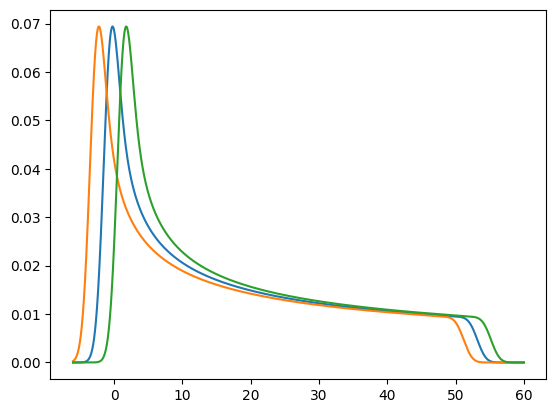

In [6]:
y_grilla = np.arange(-6,60,0.01)
plt.plot(y_grilla,p1_Y_doX(y_grilla,0))
plt.plot(y_grilla,p1_Y_doX(y_grilla,1))
plt.plot(y_grilla,p1_Y_doX(y_grilla,-1))

sum(p1_Y_doX(y_grilla,0)) * 0.01

## medias

In [7]:
def media(py_dox, ys):
    dy = ys[1] - ys[0]
    return sum(py_dox[:,0] *ys) *dy

In [8]:
# E(y) = integral( y p(y) dy) es la esperanza, el valor esperado de Y. 
# Cómo queremos la esperanza de y dada la intervención, usamos py_doX y lo aproximamos con una sumatoria...
# y * py_doX * dy dado un valor de X, en este caso comparamos para x ε {-1; 0; 1}

np.dot(y_grilla,p1_Y_doX(y_grilla,-1).reshape((6600,))) * 0.01,np.dot(y_grilla,p1_Y_doX(y_grilla,0).reshape((6600,))) * 0.01,np.dot(y_grilla,p1_Y_doX(y_grilla,1).reshape((6600,))) * 0.01

(np.float64(19.105446169207355),
 np.float64(17.10245950005898),
 np.float64(15.09998954627808))

Text(0.5, 1.0, 'P(y|do(x))')

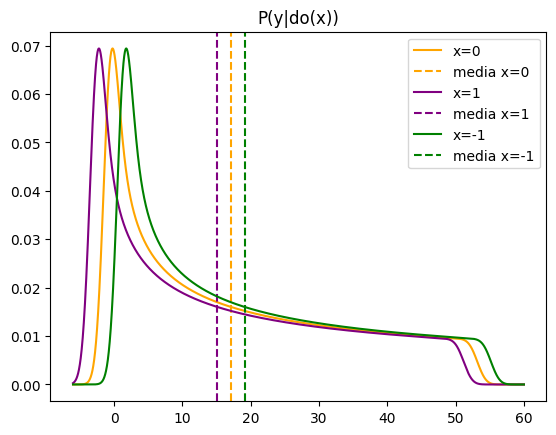

In [9]:
y_grilla = np.arange(-6, 60, 0.01)

for x, color in zip([0, 1, -1], ['orange', 'purple', 'green']):
    plt.plot(y_grilla, p1_Y_doX(y=y_grilla, x=x, blm1=blm1), label=f"x={x}", color=color)
    plt.axvline(media(p1_Y_doX(y=y_grilla, x=x, blm1=blm1), y_grilla), label=f"media x={x}", linestyle='--', color=color)
    plt.legend()

plt.title("P(y|do(x))")

In [10]:
y_grilla = np.arange(-20,80,0.01)
x_grilla = np.arange(-6,6,1)

media_backdoor = [] # media/esperanza calculada mediante la aproximación por backdoor criteria
media_exp = [] # media calculada a partir de las muestras simuladas

for x in x_grilla:
    media_backdoor.append(media(p1_Y_doX(y_grilla,x),y_grilla))
    _,_,Yx = simular1(5000, x)
    media_exp.append(np.mean(Yx))




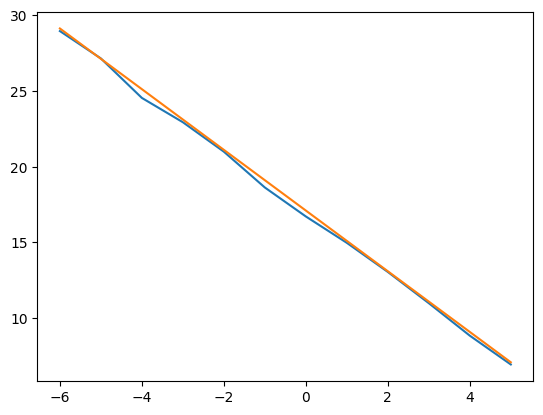

In [11]:
# comparamos las medias y confirmamos que la intervención doX funciona.
plt.plot(x_grilla,media_exp)
plt.plot(x_grilla,media_backdoor)

# Ejercicio 4

In [12]:
def simular4(N, do_x=None):
    # Si hay intervencion, usar x = do_x, sino generarlo del modelo original

    Z = np.random.normal(size=N, scale=1)
    if do_x is None:
        X = Z**2 + np.random.normal(size=N, scale=1)
    else:
        X = np.full(N, do_x)
    M = 2*Z**2 + 10*X + np.random.normal(size=N, scale=1)
    Y = -1 + 2*M**2 + np.random.normal(size=N, scale=1)
    return Z, X, M, Y

N = 10000
Z4s, X4s, M42, Y4s = simular4(N)

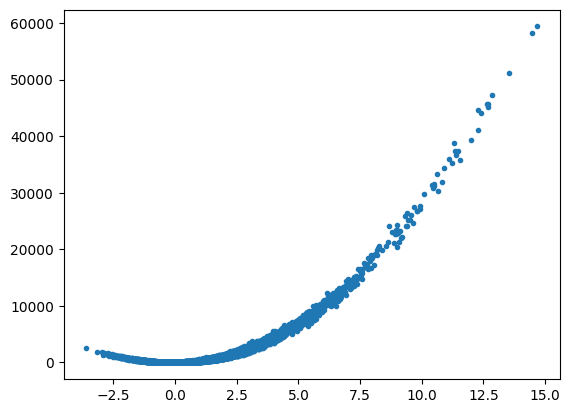

In [13]:
plt.plot(X4s, Y4s, '.')

P(z) = N (z|0, 1)

P(x|z) = N (x|z^2, 1)

P(m|x, z) = N (m|2z^2 + 10x, 1)

P(y|m) = N (y| − 1 + 2m2, 1)

Como decidimos cerrar el flujo trasero entre X e Y mediante la observación de Z, el modelo de regresión lineal nos queda:

y ~ N (−1 + 200x^2 + 80xz^2 + 8z^4, 1)


In [14]:
PHI4 = np.concatenate([
    np.ones(N).reshape(N, 1),
    (X4s**2).reshape(N, 1),
    (X4s*Z4s**2).reshape(N, 1),
    (Z4s**4).reshape(N, 1)],
    axis=1)

blm4= BayesianLinearModel(basis=lambda x: x)
blm4.update(PHI4, Y4s.reshape(N,1) )
print("Evidencia = ", blm4.evidence())

Evidencia =  -59485.604091015266


In [15]:
m4 = blm4.location
S4 = blm4.dispersion

m4

array([[  2.41908696],
       [199.79781243],
       [ 81.85402304],
       [  6.02895745]])

Cómo vemos que las medias dan como los datos reales (salvo la ordenada al origen), estimamos el efecto causal:

In [16]:
def p4_Y_doX(y, x, blm=blm4, dz=0.01):
    z_grilla = np.arange(-3, 3+dz, dz)
    pz = norm(loc=0, scale=1).pdf(z_grilla)
    res = 0
    for i, z in enumerate(z_grilla):
        _, _, py_xz = blm.predict(
            X=np.array([1, x**2, x*z**2, z**4]).reshape((1, 4)),
            y=np.array([y]), variance=True)
        res += pz[i] * py_xz * dz
    return res

In [17]:
def Y_doX(x, N=10000):
    # Generar una muestra P(y|do(x))
    Z, X, M, Y = simular4(N, do_x=x)
    return Y

(-1000.0, 5000.0)

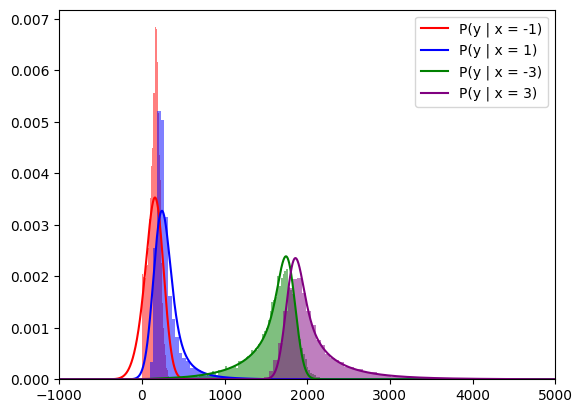

In [18]:
y_grilla = np.arange(-1000, 9000, 1)
xs = [-1, 1, -3, 3]
colores = ["red", "blue", "green", "purple"]

for x, col in zip(xs, colores):
    plt.hist(Y_doX(x), bins=100, density=True, color= col, alpha=0.5)
    plt.plot(y_grilla, p4_Y_doX(y=y_grilla,x=x), label=f"P(y | x = {x})",color= col)
plt.legend()
plt.xlim(-1000, 5000)

Lo ultimo no lo entendí, si está graficando la esperanza de y dado doX, la esperanza es un solo valor, no varía en función del Y cómo muestra el ultimo grafico del ejercicio 4...